# KiDS COSMOS SOM
The following generates a SOM for the KiDS COSMOS (deep) catalog utilizing the cell assignments from the published KiDS-1000 (wide) SOM. 

In [42]:
# import functions 

import sys
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages') #minisom location
sys.path.append('/usr/local/lib/python3.9/site-packages') #tqdm location 
sys.path.append('/Users/darshika/Desktop/Research/som/') #som codes location
sys.path.append('/usr/local/lib/python3.9/site-packages/pandas-1.4.3-py3.9-macosx-11-x86_64.egg') #pandas location

import tqdm
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import ascii
from astropy.table import Table, vstack, Column
import astropy.units as u
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.colors as colors
import pandas as pd
import minisom
from soms import generate_som
from soms import plot_som
from utils import stack_vertically
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [43]:
# read in the code vectors, vectors are the color combinations 
path = '/Users/darshika/Desktop/Research/som/'

table = Table.read(f'{path}/K1000_Spec_Train_Adapt_SOM_codebook.csv')

In [44]:
filter_1 = []
filter_2 = []
x_som = np.zeros((len(table), len(table.colnames))) # empty table to hold vectors

In [45]:
# separates the names of columns (colors) into the first filter (filter_1) - second filter (filter_2) 
for i, key in enumerate(table.colnames):
    x_som[:, i] = table[key]
    if key != 'MAG_AUTO':
        filter_1.append(key.split('-')[0].split('_')[2])
        filter_2.append(key.split('-')[1].split('_')[2])

In [46]:
# read in whitening parameters
table = Table.read(f'{path}/K1000_Spec_Train_Adapt_SOM_whitenparam.csv', format = 'csv')

In [47]:
# read in whitening parameters -- DO NOT RUN AGAIN. 
median = []
nmad = []
for i in range(len(table)):
    if table['Factor'][i] != 'MAG_AUTO':
        assert table['Factor'][i] == 'MAG_GAAP_{}-MAG_GAAP_{}'.format(
            filter_1[i], filter_2[i])
    median.append(table['Median'][i])
    nmad.append(table['nMAD'][i])

In [48]:
# read in DR4 - DO NOT RUN AGAIN. COSMOSadaptdepth_ugriZYJHKs_rot_photoz, COSMOS data of magnitudes from photometry
table = Table.read(f'{path}/COSMOSadaptdepth_ugriZYJHKs_rot_photoz (1).cat')

In [49]:
table

SeqNr,FLUX_AUTO_THELI,FLUXERR_AUTO_THELI,MAG_AUTO,MAGERR_AUTO_THELI,KRON_RADIUS_THELI,BackGr_THELI,Level_THELI,MU_THRESHOLD_THELI,MaxVal_THELI,MU_MAX_THELI,ISOAREA_WORLD_THELI,Xpos_THELI,Ypos_THELI,ALPHA_J2000,DELTA_J2000,A_WORLD,B_WORLD,THETA_J2000,ERRA_WORLD_THELI,ERRA_IMAGE_THELI,ERRB_WORLD_THELI,ERRB_IMAGE_THELI,THETA_SKY_THELI,ERRTHETA_SKY_THELI,THETA_WORLD_THELI,ERRTHETA_WORLD_THELI,FWHM_IMAGE_THELI,FWHM_WORLD_THELI,Flag_THELI,FLUX_RADIUS_THELI,NIMAFLAGS_ISO_THELI,CLASS_STAR_THELI,IMAFLAGS_ISO_THELI,X_WORLD_THELI,Y_WORLD_THELI,XY_WORLD_THELI,X2_WORLD_THELI,Y2_WORLD_THELI,ERRX2_IMAGE_THELI,ERRX2_WORLD_THELI,ERRXY_WORLD_THELI,ERRY2_WORLD_THELI,ERRXY_IMAGE_THELI,ERRY2_IMAGE_THELI,XM2_THELI,YM2_THELI,Corr_THELI,CXX_IMAGE_THELI,CXY_IMAGE_THELI,CYY_IMAGE_THELI,CXX_WORLD_THELI,CXY_WORLD_THELI,CYY_WORLD_THELI,ERRCXX_IMAGE_THELI,ERRCXY_IMAGE_THELI,ERRCYY_IMAGE_THELI,ERRCXX_WORLD_THELI,ERRCXY_WORLD_THELI,ERRCYY_WORLD_THELI,NPIX_THELI,XMIN_IMAGE_THELI,XMAX_IMAGE_THELI,YMIN_IMAGE_THELI,YMAX_IMAGE_THELI,A_THELI,B_THELI,POSANG_THELI,ERRTHETA_IMAGE_THELI,ELLIPTICITY_THELI,ELONGATION_THELI,ISO0_THELI,ISO1_THELI,ISO2_THELI,ISO3_THELI,ISO4_THELI,ISO5_THELI,ISO6_THELI,ISO7_THELI,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,MAG_LIM_u,MAG_LIM_g,MAG_LIM_r,MAG_LIM_i,MAG_ISO_THELI,MAGERR_ISO_THELI,MAG_ISOCOR_THELI,MAGERR_ISOCOR_THELI,MAG_BEST_THELI,MAGERR_BEST_THELI,MAG_APER_THELI,MAGERR_APER_THELI,FLUX_BEST_THELI,FLUXERR_BEST_THELI,FLUX_ISO_THELI,FLUXERR_ISO_THELI,FLUX_ISOCOR_THELI,FLUXERR_ISOCOR_THELI,FLUX_APER_4_THELI,FLUX_APER_5_THELI,FLUX_APER_6_THELI,FLUX_APER_7_THELI,FLUX_APER_8_THELI,FLUX_APER_9_THELI,FLUX_APER_10_THELI,FLUX_APER_11_THELI,FLUX_APER_12_THELI,FLUX_APER_13_THELI,FLUX_APER_14_THELI,FLUX_APER_15_THELI,FLUX_APER_16_THELI,FLUX_APER_17_THELI,FLUX_APER_18_THELI,FLUX_APER_19_THELI,FLUX_APER_20_THELI,FLUX_APER_25_THELI,FLUX_APER_30_THELI,FLUX_APER_35_THELI,FLUX_APER_40_THELI,FLUX_APER_45_THELI,FLUX_APER_50_THELI,FLUX_APER_55_THELI,FLUXERR_APER_4_THELI,FLUXERR_APER_5_THELI,FLUXERR_APER_6_THELI,FLUXERR_APER_7_THELI,FLUXERR_APER_8_THELI,FLUXERR_APER_9_THELI,FLUXERR_APER_10_THELI,FLUXERR_APER_11_THELI,FLUXERR_APER_12_THELI,FLUXERR_APER_13_THELI,FLUXERR_APER_14_THELI,FLUXERR_APER_15_THELI,FLUXERR_APER_16_THELI,FLUXERR_APER_17_THELI,FLUXERR_APER_18_THELI,FLUXERR_APER_19_THELI,FLUXERR_APER_20_THELI,FLUXERR_APER_25_THELI,FLUXERR_APER_30_THELI,FLUXERR_APER_35_THELI,FLUXERR_APER_40_THELI,FLUXERR_APER_45_THELI,FLUXERR_APER_50_THELI,FLUXERR_APER_55_THELI,Agaper_u,Bgaper_u,PAgaap_u,MAG_GAAP_u,MAGERR_GAAP_u,FLUX_GAAP_u,FLUXERR_GAAP_u,Agaper_g,Bgaper_g,PAgaap_g,MAG_GAAP_g,MAGERR_GAAP_g,FLUX_GAAP_g,FLUXERR_GAAP_g,Agaper_r,Bgaper_r,PAgaap_r,MAG_GAAP_r,MAGERR_GAAP_r,FLUX_GAAP_r,FLUXERR_GAAP_r,Agaper_i,Bgaper_i,PAgaap_i,MAG_GAAP_i,MAGERR_GAAP_i,FLUX_GAAP_i,FLUXERR_GAAP_i,Z_B_ugri,Z_B_MIN_ugri,Z_B_MAX_ugri,T_B_ugri,ODDS_ugri,Z_ML_ugri,T_ML_ugri,CHI_SQUARED_BPZ_ugri,M_0_ugri,FIELD_POS,PZ_full [351],Flag,MAG_GAAP_Z,MAGERR_GAAP_Z,FLUX_GAAP_Z,FLUXERR_GAAP_Z,GAAP_Flag_Z,GAAP_nexp_Z,MAG_GAAP_Y,MAGERR_GAAP_Y,FLUX_GAAP_Y,FLUXERR_GAAP_Y,GAAP_Flag_Y,GAAP_nexp_Y,MAG_GAAP_J,MAGERR_GAAP_J,FLUX_GAAP_J,FLUXERR_GAAP_J,GAAP_Flag_J,GAAP_nexp_J,MAG_GAAP_H,MAGERR_GAAP_H,FLUX_GAAP_H,FLUXERR_GAAP_H,GAAP_Flag_H,GAAP_nexp_H,MAG_GAAP_Ks,MAGERR_GAAP_Ks,FLUX_GAAP_Ks,FLUXERR_GAAP_Ks,GAAP_Flag_Ks,GAAP_nexp_Ks,EXTINCTION_Z,EXTINCTION_Y,EXTINCTION_J,EXTINCTION_H,EXTINCTION_Ks,MAG_LIM_Z,MAG_LIM_Y,MAG_LIM_J,MAG_LIM_H,MAG_LIM_Ks,GAAP_Flag_u,GAAP_Flag_g,GAAP_Flag_r,GAAP_Flag_i,MAG_GAAPadapt_Z,MAG_GAAPadapt_Y,MAG_GAAPadapt_J,MAG_GAAPadapt_H,MAG_GAAPadapt_Ks,MAGERR_GAAPadapt_Z,MAGERR_GAAPadapt_Y,MAGERR_GAAPadapt_J,MAGERR_GAAPadapt_H,MAGERR_GAAPadapt_Ks,MAG_GAAPadapt_u,MAG_GAAPadapt_g,MAG_GAAPadapt_r,MAG_GAAPadapt_i,MAGERR_GAAPadapt_u,MAGERR_GAAPadapt_g,MAGERR_GAAPadapt_r,MAGERR_GAAPadapt_i,Z_B,Z_B_MIN,Z_B_MAX,T_B,ODDS,Z_ML,T_ML,CHI_SQUARED_BPZ,M_0,BPZ_FILT,NBPZ_FILT,BPZ_NONDETFILT,NBPZ_NONDETFILT,BPZ_FLAGFILT,NBPZ_FLAGFILT,GAAP_Flag_ugriZYJHKs,MASK,recal_weight
"""""",ct,ct,mag,c

In [50]:
#reluctantly convert this to Pandas DataFrame
#names = [name for name in table.colnames if len(table[name].shape) <= 1] # filtering out multi-dimensional columns
#table = table[names].to_pandas() # commented out after turning to pandas
type(table)

astropy.table.table.Table

In [51]:
# reluctantly convert this to Pandas DataFrame
names = [name for name in table.colnames if len(table[name].shape) <= 1]

table = table[names].to_pandas()
table

,SeqNr,FLUX_AUTO_THELI,FLUXERR_AUTO_THELI,MAG_AUTO,MAGERR_AUTO_THELI,KRON_RADIUS_THELI,BackGr_THELI,Level_THELI,MU_THRESHOLD_THELI,MaxVal_THELI,...,M_0,BPZ_FILT,NBPZ_FILT,BPZ_NONDETFILT,NBPZ_NONDETFILT,BPZ_FLAGFILT,NBPZ_FLAGFILT,GAAP_Flag_ugriZYJHKs,MASK,recal_weight
0,1475,11.400084,0.461091,22.017731,0.043925,3.808854,-0.003500,0.042345,25.084238,0.297399,...,21.139,511,9,0,0,0,0,0,0,13.742792
1,1484,1.592592,0.322762,24.154739,0.220094,7.172558,-0.002426,0.042132,25.084238,0.112945,...,24.041,103,5,0,0,408,4,0,0,1.364414
2,1485,3.801996,0.326973,23.209970,0.093396,4.399350,0.000250,0.041863,25.084238,0.150569,...,22.496,510,8,0,0,1,1,0,0,12.270452
3,1493,1.131001,0.223983,24.526342,0.215071,4.364545,0.001532,0.042266,25.084238,0.090751,...,24.419,502,7,0,0,9,2,0,0,8.262316
4,1500,10.900190,0.480740,22.066414,0.047897,5.184607,0.003610,0.042159,25.084238,0.422464,...,21.437,511,9,0,0,0,0,0,0,14.812298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100409,143289,4.327503,0.352914,23.069407,0.088565,5.255905,0.000025,0.043483,25.084238,0.277667,...,22.462,511,9,0,0,0,0,0,0,14.502539
100410,143290,2.624542,0.351532,23.612366,0.145459,4.990303,-0.002489,0.042534,25.084238,0.145602,...,22.924,510,8,0,0,1,1,0,0,10.053946
100411,143293,0.836570,0.194151,24.853745,0.252039,5.507090,-0.001613,0.035323,25.084238,0.088409,...,24.304,30,4,0,0,481,5,0,0,6.534268
100412,143294,0.733019,0.181602,24.997211,0.269051,5.270247,-0.002092,0.042693,25.084238,0.088447,...,24.781,478,7,0,0,33,2,0,0,0.289302


In [52]:
# replace every 99.0 with np.nan (please, please work. :()), nan = not a number 
table.replace(to_replace = 99.0, value = np.nan, inplace = True)
print(table['MAG_GAAP_u'])
#print(table)

0         23.799412
1         24.116241
2               NaN
3               NaN
4         24.636934
            ...    
100409    24.474525
100410          NaN
100411          NaN
100412          NaN
100413          NaN
Name: MAG_GAAP_u, Length: 100414, dtype: float32


In [53]:
# COSMOS
x_cosmos = np.zeros((len(table), x_som.shape[1]))
for i, (f1, f2) in enumerate(zip(filter_1, filter_2)):
    x_cosmos[:, i] = (
        table['MAG_GAAP_{}'.format(f1)] - table['MAG_GAAP_{}'.format(f2)])
x_cosmos[:, -1] = table['MAG_AUTO']

In [54]:
# unwhiten COSMOS
for i, (m, n) in enumerate(zip(median, nmad)):
    x_cosmos[:, i] = (x_cosmos[:, i] - m) / n

In [55]:
# fully functional - DO NOT EDIT. :) 
# pair COSMOS with winning cell (stop once a reasonable number is reached)
# note: here, since we're not doing a direct comparison, did not add "1"
# to index values. Could probably add it if I am indeed doing a direct comparison. 

i_cosmos = []
shape = (101,101)

for i in tqdm.tqdm(range(len(x_cosmos))):
    i_cosmos.append(np.unravel_index((np.argmin(np.nansum((x_cosmos[i] - x_som)**2, axis=-1))), shape))

100%|█████████████████████████████████| 100414/100414 [01:30<00:00, 1113.12it/s]


In [56]:
len(i_cosmos) # holds the index of the winning cell for each galaxy
# print(i_cosmos)

100414

In [57]:
len(x_som)

10201

# Generate Map of Winners

In [58]:
# generate map of winners from scratch! 

win_map = defaultdict(list)
return_indices = True

for i, x in enumerate(i_cosmos): 
    win_map[x].append(i if return_indices else x)

win_map;

In [59]:
# create empty "map" to hold occupation in each cell
occ_map = np.zeros(shape)

# generate occupation map
for iy, ix in np.ndindex(occ_map.shape):  
    occ_map[iy, ix] = len(win_map[(iy,ix)])

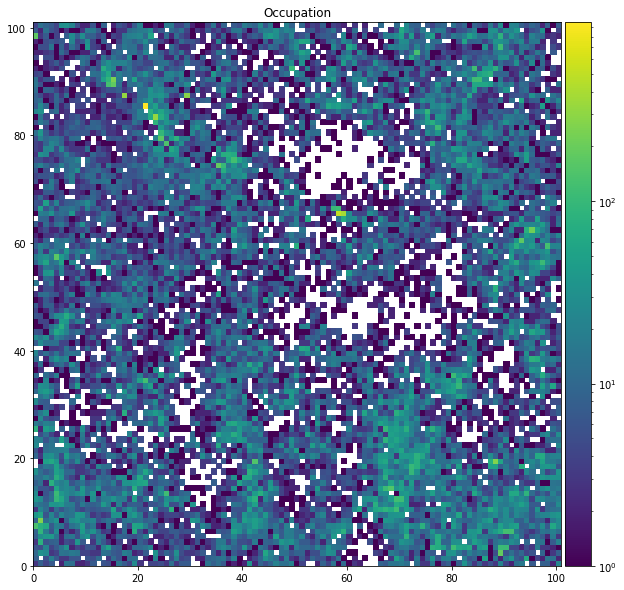

In [60]:
# plot figure
n_plots = 1 
n_cols = 1

n_rows = n_plots // n_cols
n_rows += n_plots % n_cols
    
pos_plots = range(1, n_plots + 1) 
    
# main figure
fig = plt.figure(figsize = (10,10))

labels = []
labels.append('Occupation') 

plots = []
plots.append(occ_map)

for ii in range(n_plots): 
    ax = fig.add_subplot(n_rows, n_cols, pos_plots[ii]) 
    
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes('right', size='5%', pad=0.05)
        
    if labels[ii] == 'Occupation': 
        im = ax.pcolor(plots[ii], cmap = 'viridis', norm = colors.LogNorm())
    else:
        im = ax.pcolor(plots[ii], cmap = 'viridis')
        
    fig.colorbar(im, cax = cax, orientation = 'vertical') 
        
    ax.title.set_text(labels[ii])

# Generate Color Maps
In principle, I've already calculated the colors... No need to calculate again! 

In [61]:
# empty "map" to hold median zs
med_g_r_map = np.zeros(occ_map.shape)
c = 2 # index that holds g-r color in x_cosmos
for iy, ix in np.ndindex(med_g_r_map.shape): 
    med_g_r_map[iy, ix] = np.median([gal[c] for gal in x_cosmos[win_map[(ix,iy)]]]) 
        

/Users/darshika/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/darshika/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


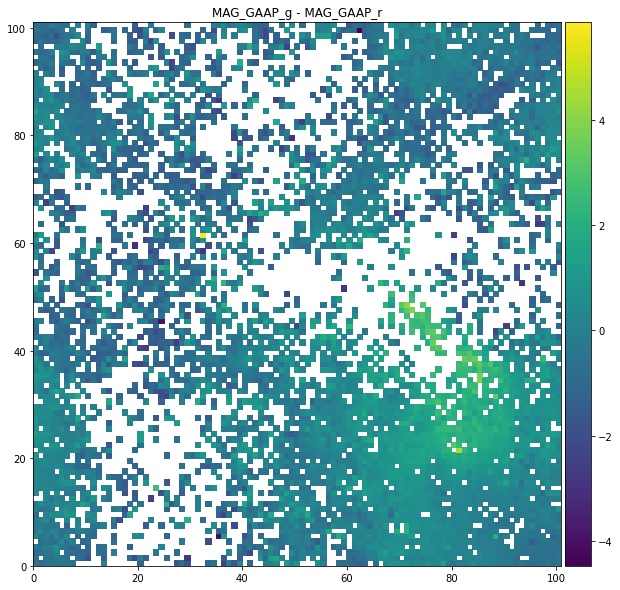

In [62]:
# plot figure
n_plots = 1 
n_cols = 1

n_rows = n_plots // n_cols
n_rows += n_plots % n_cols
    
pos_plots = range(1, n_plots + 1) 
    
# main figure
fig = plt.figure(figsize = (10,10))

labels = []
labels.append('MAG_GAAP_g - MAG_GAAP_r') 

plots = []
plots.append(med_g_r_map)

for ii in range(n_plots): 
    ax = fig.add_subplot(n_rows, n_cols, pos_plots[ii]) 
    
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes('right', size='5%', pad=0.05)
        
    if labels[ii] == 'Occupation': 
        im = ax.pcolor(plots[ii], cmap = 'viridis', norm = colors.LogNorm())
    else:
        im = ax.pcolor(plots[ii], cmap = 'viridis')
        
    fig.colorbar(im, cax = cax, orientation = 'vertical') 
        
    ax.title.set_text(labels[ii])

Text(0.5, 1.0, 'MAG_GAAP_g - MAG_GAAP_r')

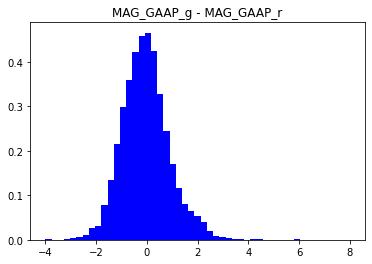

In [63]:
plt.hist(np.hstack(med_g_r_map), bins=np.linspace(-4, 8, 50), density = True, color = 'blue'); 
plt.title('MAG_GAAP_g - MAG_GAAP_r')

# Generate Deep Weights

In [178]:
# data path 
path = '/Users/darshika/Desktop/Research/som/'

# import data
c3r2_cosmos_table = Table.read(f'{path}/lensing_cosmos_extended.fits')
c3r2_vvds_table = Table.read(f'{path}/lensing_vvds_extended.fits')

# vertically stack data
c3r2_table = stack_vertically(
                            c3r2_cosmos_table, 
                            c3r2_vvds_table, 
                            'lensing_cosmos_extended.fits', 
                            'lensing_vvds_extended.fits')
catalog = c3r2_table

In [179]:
w_d_map = np.zeros(occ_map.shape)

for iy, ix in np.ndindex(w_d_map.shape): 
    # first, determine if N_z(c_k) == 0, if so, arbitrarily set weight as 'NaN'
    # (this means that none of the galaxies from the deep sample that fall into 
    # that color cell do NOT have a match in the redshift sample
    
    # store galaxies with zs from deep  sample (probably a better way to name this)
    gals_w_z_deep = win_map[(iy,ix)]

    # store galaxies with zs from redshift sample (probably a better way to name this)
    gals_w_z_redshift = catalog[win_map[(iy,ix)]][np.where(catalog[win_map[(iy,ix)]]['has_z_spec'] == True)]

    # count N_d and N_z 
    N_d = len(win_map[(iy,ix)]) 
    N_z = len(gals_w_z_redshift) 
    
    if N_z != 0: 
        w_d_map[iy, ix] = N_d / N_z 
    
    elif N_z == 0: 
        w_d_map[iy, ix] = None
            


In [180]:
z_occ_map = np.zeros(occ_map.shape)

for iy, ix in np.ndindex(z_occ_map.shape): 
    # first, determine if N_z(c_k) == 0, if so, arbitrarily set weight as 'NaN'
    # (this means that none of the galaxies from the deep sample that fall into 
    # that color cell do NOT have a match in the redshift sample
    
    # store galaxies with zs from deep  sample (probably a better way to name this)
    gals_w_z_deep = win_map[(iy,ix)]

    # store galaxies with zs from redshift sample (probably a better way to name this)
    gals_w_z_redshift = catalog[win_map[(iy,ix)]][np.where(catalog[win_map[(iy,ix)]]['has_z_spec'] == True)]

    # count N_z 
    N_z = len(gals_w_z_redshift) 
    
    if N_z != 0: 
        z_occ_map[iy, ix] = N_z
    
    elif N_z == 0: 
        z_occ_map[iy, ix] = None
            


In [181]:
median_z_map = np.zeros(occ_map.shape)

for iy, ix in np.ndindex(median_z_map.shape): 
    median_z_map[iy, ix] = np.median(catalog[win_map[(iy, ix)]]['z_spec'])

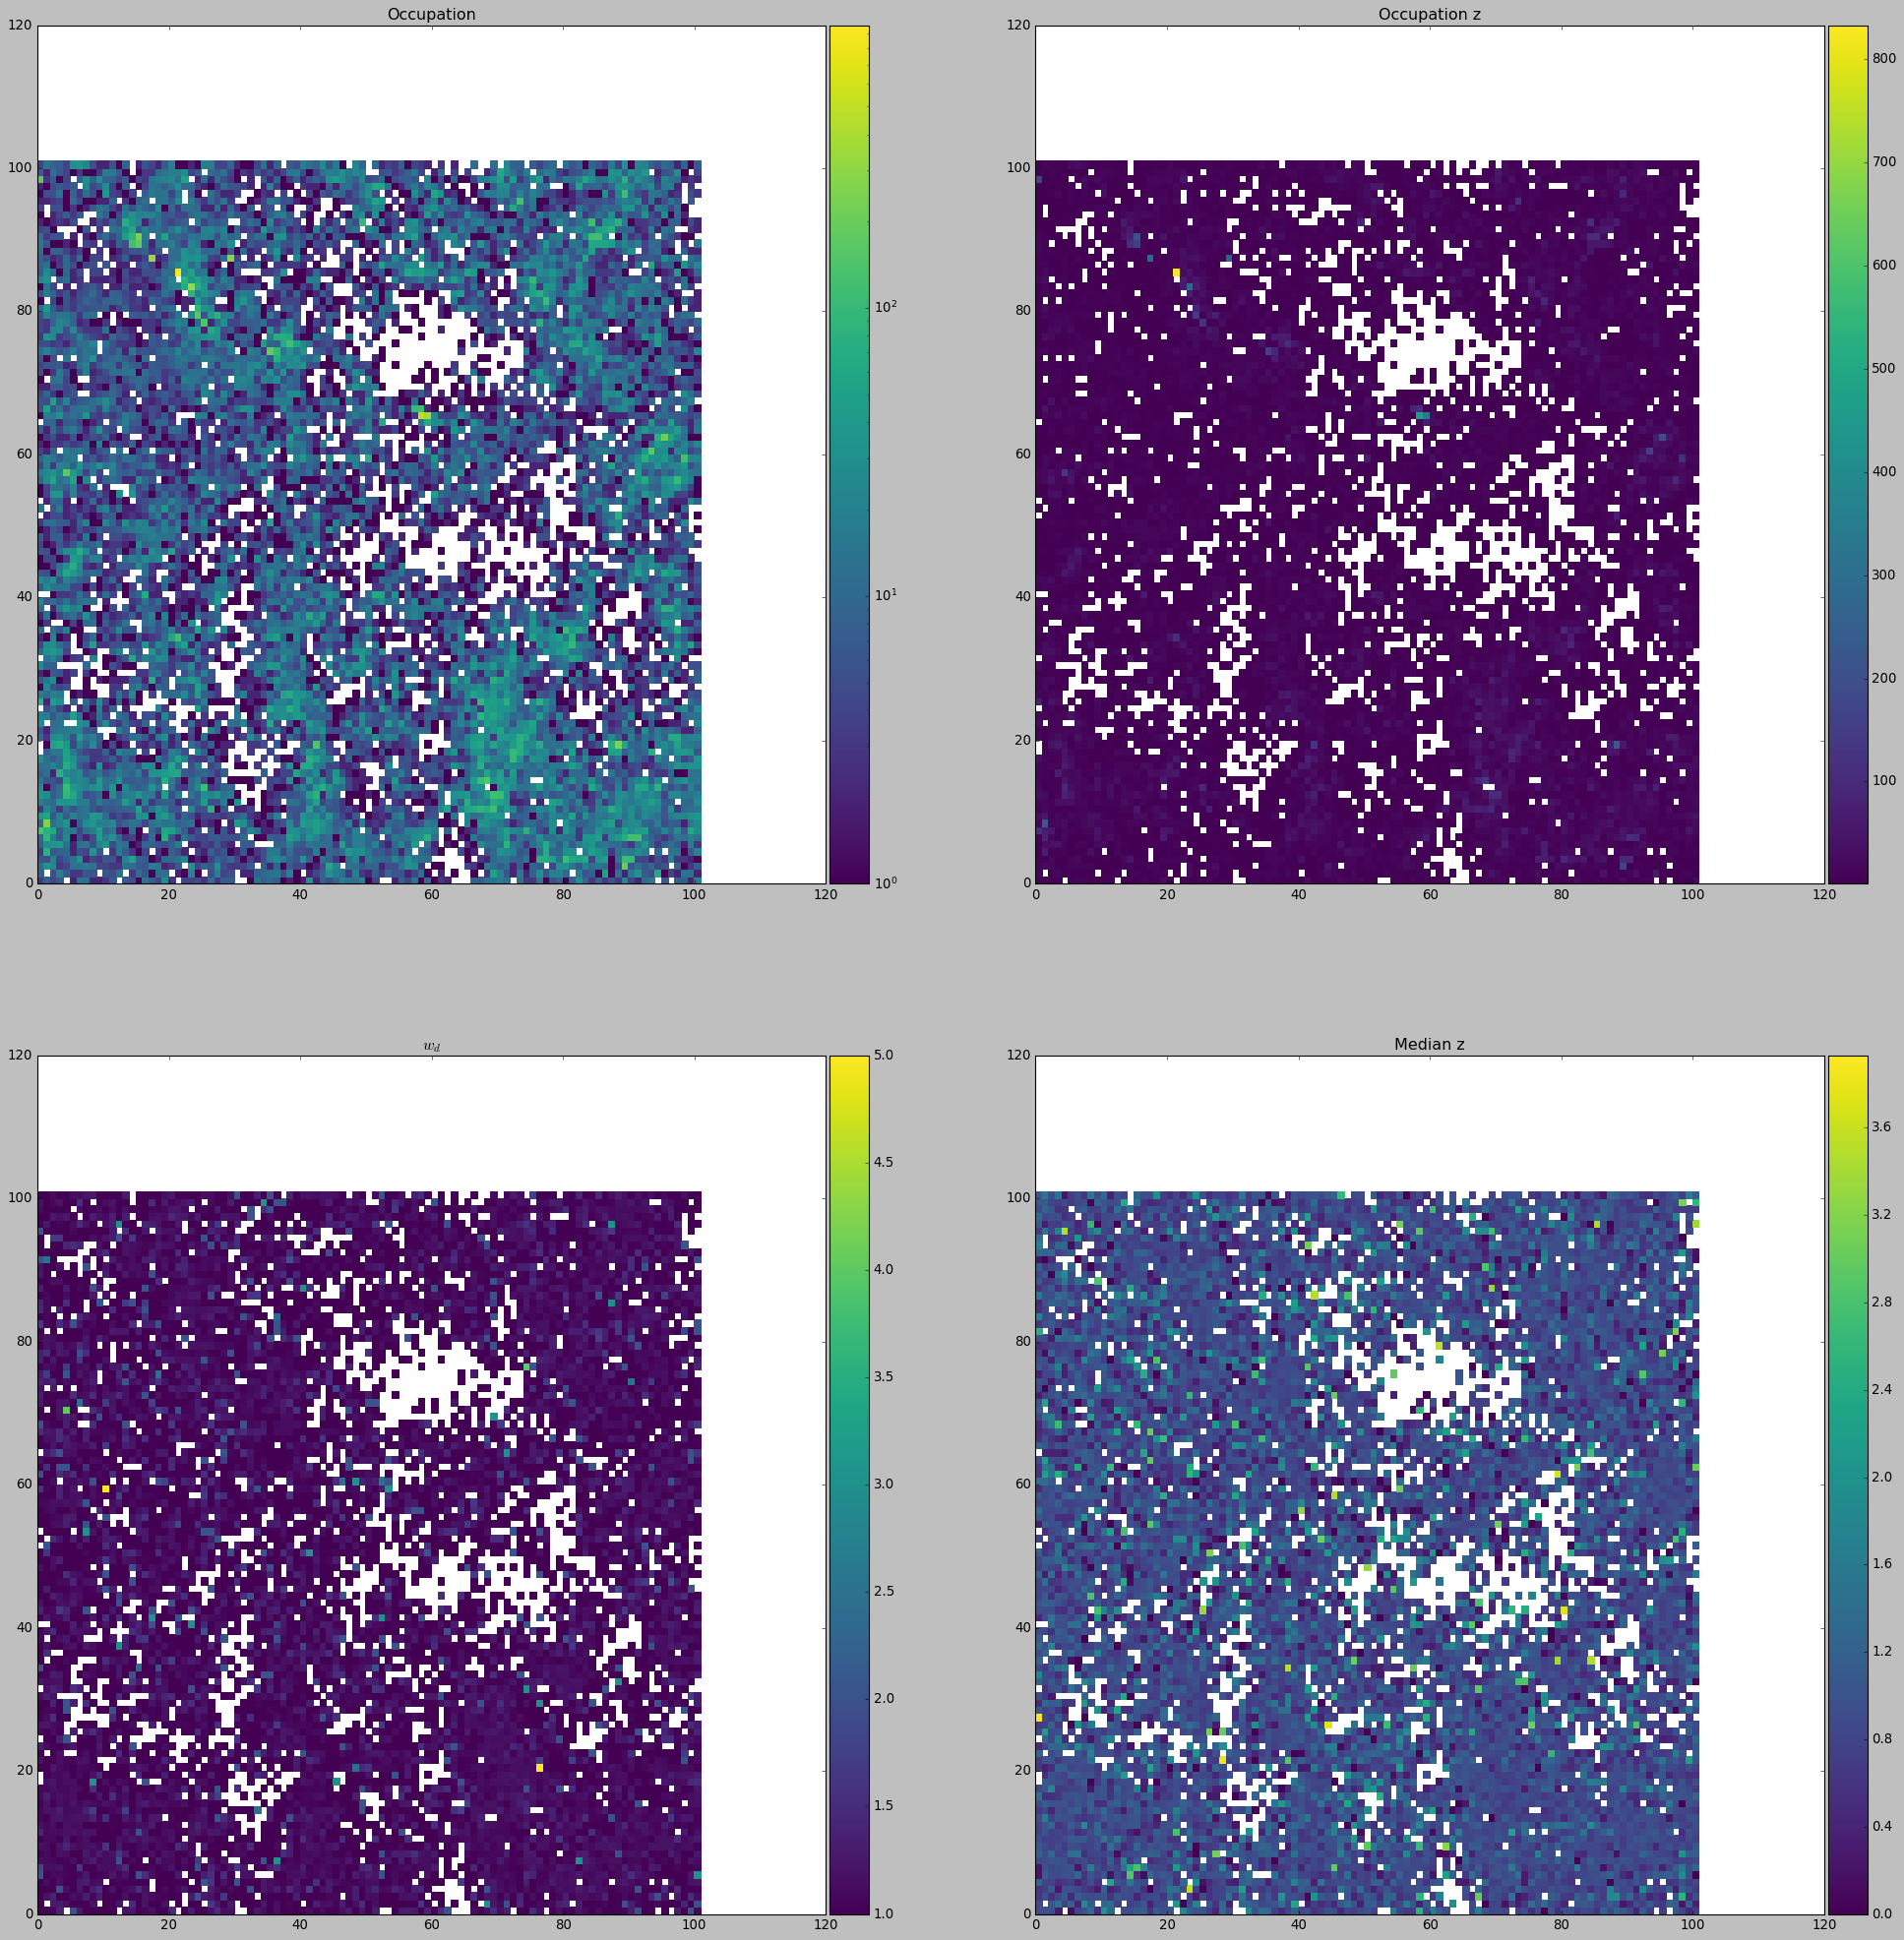

In [182]:
# plot figure
n_plots = 4
n_cols = 2

n_rows = n_plots // n_cols
n_rows += n_plots % n_cols
    
pos_plots = range(1, n_plots + 1) 
    
# main figure
fig = plt.figure(figsize = (30,30))

labels = []
labels.append('Occupation')
labels.append('Occupation z')
labels.append('$w_{d}$')
labels.append('Median z')


plots = []
plots.append(occ_map)
plots.append(z_occ_map)
plots.append(w_d_map)
plots.append(median_z_map)

for ii in range(n_plots): 
    ax = fig.add_subplot(n_rows, n_cols, pos_plots[ii]) 
    
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes('right', size='5%', pad=0.05)
        
    if labels[ii] == 'Occupation': 
        im = ax.pcolor(plots[ii], cmap = 'viridis', norm = colors.LogNorm())
    else:
        im = ax.pcolor(plots[ii], cmap = 'viridis')
        
    fig.colorbar(im, cax = cax, orientation = 'vertical') 
        
    ax.title.set_text(labels[ii])
    
#w_d = weight for each cell, based on number of galaxies in each cell, lower amount of galaxies higher the weight



# Re-Weighed Histograms
Here, the redshift distribution histograms generated per redshift bin are generated, while taking into account the deep weights! 

In [183]:
# data path
kids_path = '/Users/darshika/Desktop/Research/som/'
specz_path = '/Users/darshika/Desktop/Research/som/'


In [184]:
# read in DR4 - DO NOT RUN AGAIN. KiDS COSMOS
kids_table = Table.read(f'{kids_path}/COSMOSadaptdepth_ugriZYJHKs_rot_photoz (1).cat')

In [186]:
#USE THIS CELL
# re-weigh using deep weights
# add a column to table to hold weights, #result = values[np.where( (values>2) & (values<4))] example
w_d_column = Column(name = 'w_d', data = np.array([1]*(len(catalog))))
catalog.add_column(w_d_column) # uncomment if adding for the first time

for iy, ix in np.ndindex(median_z_map.shape): 
    for k in win_map[iy,ix]: 
        #print(k)
        try: # Please come back to this and debug... raises error when k = NaN 
            catalog[k]['w_d'] = w_d_map[iy,ix]
        except (ValueError): 
            pass
#catalog = catalog[np.where(catalog['has_z_SDSS_DR16'] & ['has_z_PRIMUS'] == True)]
catalog = catalog[np.where( ((catalog['has_z_eBOSS_LRG'] == True) or 
                             (catalog['has_z_eBOSS_ELG'] == True) or
                           (catalog['has_z_SDSS_DR16'] == True) or
                             (catalog['has_z_OzDES']== True) or 
                              (catalog['has_z_c3r2_dr2']==True) or
                           (catalog['has_z_VIPERS_W1']== True) or
                             (catalog['has_z_GAMA_DR3']==True) or 
                             (catalog['has_z_MMTBinospec']==True) or 
                           (catalog['has_z_deimos']==True) or 
                             (catalog['has_z_LEGA_C_DR2']==True) or 
                             (catalog['has_z_mosdef']==True) or 
                           (catalog['has_z_vvds_spF10_WIDE']==True) or 
                             (catalog['has_z_vvds_spF02_DEEP']==True) or
                           (catalog['has_z_zcosbrightspec20k_dr3'] == True)))] #has_z_spec is mislabelled in data table, spectroscopy and photometry 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [187]:
# functions 
# upon next iteration, create a python script to hold these 
def vertical_stack(catalog_1, catalog_2, id_1, id_2): 
    """ 
    Stacks two catalogs vertically, retaining origin information. 
    
    Parameters 
    ----------
    catalog_1: (astropy.Table)
        The first catalog in the stack.
    catalog_2: (astropy.Table)
        The second catalog in the stack. 
    id_1: (str)
        The identifying information for the first catalog. (i.e., catalog name?)
    id_2: (str)
        The identifying information for the second catalog. 
        
    Returns
    -------
        
    """
    
    # add a column to both catalog 1 and catalog 2 to store identifiers
    # initialize columns
    col_1 = Column(name = 'catalog_name', data = np.full(len(catalog_1), str(id_1))) 
    col_2 = Column(name = 'catalog_name', data = np.full(len(catalog_2), str(id_2)))
    
    # add columns to catalogs
    catalog_1.add_column(col_1)
    catalog_2.add_column(col_2)
    
    # vertically stack catalogs 
    stacked_catalog = vstack((catalog_1, catalog_2))
    
    return stacked_catalog

def convert_coordinates(catalog): 
    """
    Converts the Ra and Dec in the catalog from (hourangle, degree) to (degree, degree). 
    
    Parameters
    ----------
    catalog: (astropy.Table)
        Catalog requiring conversion. 
    
    Returns
    -------
    catalog: (astropy.Table)
        Catalog with additional columns holding converted positions. 
    """

    ra_h = np.array(catalog['RAh'])
    ra_m = np.array(catalog['RAm'])
    ra_s = np.array(catalog['RAs'])
    dec_sign = np.array(catalog['DE-'])
    dec_d = np.array(catalog['DEd'])
    dec_m = np.array(catalog['DEm'])
    dec_s = np.array(catalog['DEs'])
    coords_list = [] 

    # store coord into SkyCoord for easier conversion to deg + comparison with HSC 
    coords_list = [SkyCoord(f'{ra_h[i]}h{ra_m[i]}m{ra_s[i]}s', f'{dec_sign[i]}{dec_d[i]}d{dec_m[i]}m{dec_s[i]}s', unit = (u.hourangle, u.deg)) for i, obj in enumerate(catalog)]
    col_ra = [Column(name = 'RAd', data = coords_list[i].ra*u.deg/u.deg) for i, obj in enumerate(catalog)]
    col_dec = [Column(name = 'DEd', data = coords_list[i].dec*u.deg/u.deg) for i, obj in enumerate(catalog)]

    # add columns to catalog 
    catalog.add_column(col_ra*u.deg, name = 'RAdeg')
    catalog.add_column(col_dec*u.deg, name = 'DEdeg')

    return catalog

def get_ra_dec(catalog, ra_str, dec_str): 
    """
    Creates list of RA and Decs for the input catalog.
    
    Parameters 
    ----------
    catalog : (astropy.Table)
        An astropy Table containing the catalog. 
    ra_str : (str)
        String used for RA header
    dec_str : str
        String used for the Dec header
        
    Returns
    -------
    ra : (list)
        List containing the RAs of objects.
    dec : (list)
        List containing the Decs of the objects. 
    
    """
    ra = list(catalog[ra_str])
    dec = list(catalog[dec_str])
    
    return(ra, dec)

def create_sky_coord(ra, dec, deg = True, ra_u = None, dec_u = None): 
    """
    Creates SkyCoord object for match_catalogs function. 
    
    Parameters 
    ----------
    ra : (list) or (str)
        List containing RAs of the objects. 
        Or RA of the object.
    dec : (list) or (str)
        List containing Decs of the objects. 
        Or Dec of the object. 
    deg : (bool)
        Is the coordinate already in degrees?
    ra_u : (astropy.unit) or (None)
        RA unit.
    dec_u : (astropy.unit) or (None)
        Dec unit. 
        
    
    Returns 
    -------
    sky_coord : (astropy.coordinates.SkyCoord)
        SkyCoord object containing positional information, 
        including units and separation (dimensionless, set to 1).
    """
    if deg == True: 
        sky_coord = SkyCoord(ra*u.deg, dec*u.deg)
    else: 
        sky_coord = SkyCoord(ra, dec, unit = (ra_u, dec_u))
    
    return sky_coord

def match_catalogs(catalog1_coord, catalog2_coord): 
    """
    Matches two catalogs based on coordinates. 
    Note: Assumes coords are in RA and Dec (degrees). 
    
    Parameters 
    ----------
    catalog1_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 1
    catalog2_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 2
        
    Return
    ------
    idx : (list)
        Indices into catalog2_coord that are the closest objects 
        to each of the coordinates in catalog1_coord
    d2d : (list)
        On-sky distances between them 
    d3d : (list)
        3D distances between them
    """
    idx, d2d, d3d = catalog1_coord.match_to_catalog_sky(catalog2_coord)
    
    return idx, d2d, d3d

def get_matches(max_sep, catalog1_coord, catalog2_coord, catalog1, catalog2): 
    """
    Matches two catalogs based on coordinates using match_catalogs. 
    Prints matches considering separation constraint. 
    
    Parameters 
    ----------
    max_sep : (float)
        Maximum separation to be considered a match (arcsec)
    catalog1_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 1
    catalog2_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 2    
    
    Return
    ------
    catalog1_matches : (list)
        List containing matched sources separated by less than 
        max_sep in catalog1
    catalog2_matches : (list)
        List containing matched sources separated by less than 
        max_sep in catalog2
    """
    # add units to max separation 
    max_sep = max_sep * u.arcsec
    idx, d2d, d3d = match_catalogs(catalog1_coord, catalog2_coord)
    separation_constraint = d2d < max_sep 
    
    catalog1_matches = catalog1[separation_constraint]
    catalog2_matches = catalog2[idx[separation_constraint]]
    
    return catalog1_matches, catalog2_matches

In [188]:
# create SkyCoord for each catalog
# obtain ra and dec for each catalog
c3r2_table_ra, c3r2_table_dec = get_ra_dec(catalog, 'RA', 'DEC')
kids_table_ra, kids_table_dec = get_ra_dec(kids_table, 'ALPHA_J2000', 'DELTA_J2000')

# create SkyCoord object for each catalog
c3r2_table_sky_coord = create_sky_coord(c3r2_table_ra, c3r2_table_dec) 
kids_table_sky_coord = create_sky_coord(kids_table_ra, kids_table_dec) 

# find matches, matching the galaxies in the two tables, in Japan guy table and KiDS table, there are some galaxies we don't know, so these are matching the ones we do know 
c3r2_kids_idx, c3r2_kids_d2d, c3r2_kids_d3d = match_catalogs(c3r2_table_sky_coord, kids_table_sky_coord)

# print matches
# obtain matches within 1 arcsec
c3r2_kids_matches, kids_c3r2_matches = get_matches(1, c3r2_table_sky_coord, kids_table_sky_coord, catalog, kids_table)
print(f'There are {len(c3r2_kids_matches)} matches in C3R2 x KiDS.') # note this is KiDS in COSMOS

There are 87683 matches in C3R2 x KiDS.


In [189]:
# here, we are binning by Z_B, putting each of the matches 
# create bins
bin_1 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.1), (kids_c3r2_matches['Z_B'] <= 0.3)))]
bin_2 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.3), (kids_c3r2_matches['Z_B'] <= 0.5)))]
bin_3 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.5), (kids_c3r2_matches['Z_B'] <= 0.7)))]
bin_4 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.7), (kids_c3r2_matches['Z_B'] <= 0.9)))]
bin_5 = c3r2_kids_matches[np.where(np.logical_and( (kids_c3r2_matches['Z_B'] > 0.9), (kids_c3r2_matches['Z_B'] <= 1.2)))]                 

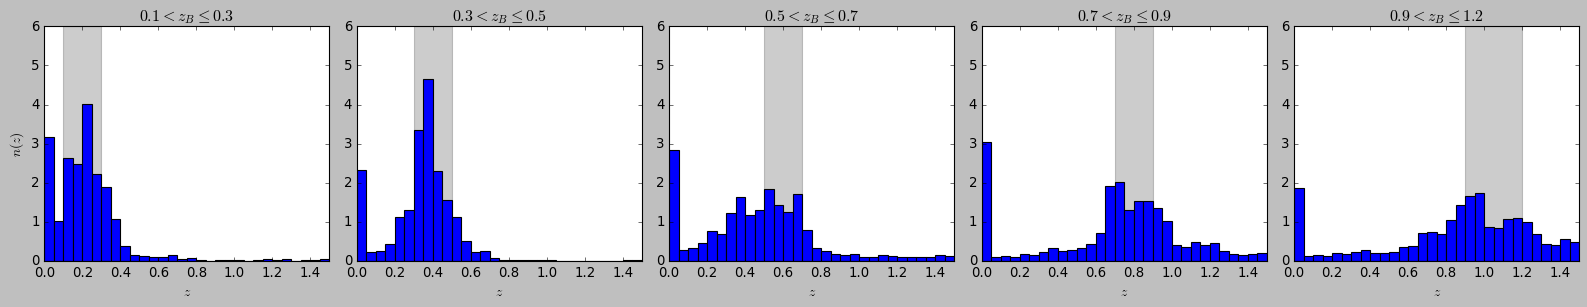

In [190]:
# plot distributions according to bin
plt.style.use('classic')
bins = [bin_1, bin_2, bin_3, bin_4, bin_5]
bins_names = ['$0.1<z_{B} \leq 0.3$', '$0.3<z_{B} \leq 0.5$', '$0.5<z_{B} \leq 0.7$', '$0.7<z_{B} \leq 0.9$', '$0.9<z_{B} \leq 1.2$']
bins_ranges = [(0.1, 0.3), (0.3, 0.5), (0.5, 0.7), (0.7, 0.9), (0.9, 1.2)]

fig,ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
plt_ind = np.arange(5) + 151

i = 0
for binss, ind in zip(bins, plt_ind):
    plt.subplot(ind);
    
    plt.axvspan(bins_ranges[i][0], bins_ranges[i][1], color='black', alpha=0.2)
    
    #binsss = [x for x in binss if x['z_spec'] != 0]
    
    n, b, p = plt.hist(binss['z_spec'], bins = 30, range = (0., 1.5), density = True, weights = binss['w_d'])
    #n, b, p = plt.hist(binsss['z_spec'], bins = 30, range = (0., 1.5), density = True, weights = binsss['w_d'])

    #print(f'There are {len(photoz_specz_matches)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')
    plt.title(bins_names[i])
    
    if i == 0: 
        plt.ylabel('$n(z)$')
    
    plt.xlabel('$z$')
    
    # limits
    plt.xlim((0,1.5))
    plt.ylim((0,6))

    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    i+=1
    
#plt.show()
plt.tight_layout()
#plt.savefig('c3r2_kids_redshift_distribution.png')

In [131]:
# might be fun to at one point actually compare them...?

In [134]:
# data path 
path = '/Users/darshika/Desktop/Research/som/'
# import data

ValueError: cannot reshape array of size 11118159 into shape (21262011,)

In [95]:
# KiDS GAAP colors
# u, g, r, i, Z, Y, J, H
filts = list('ugriZYJH')
c_filts = filts # double check

NameError: name 'kids_gold_table' is not defined

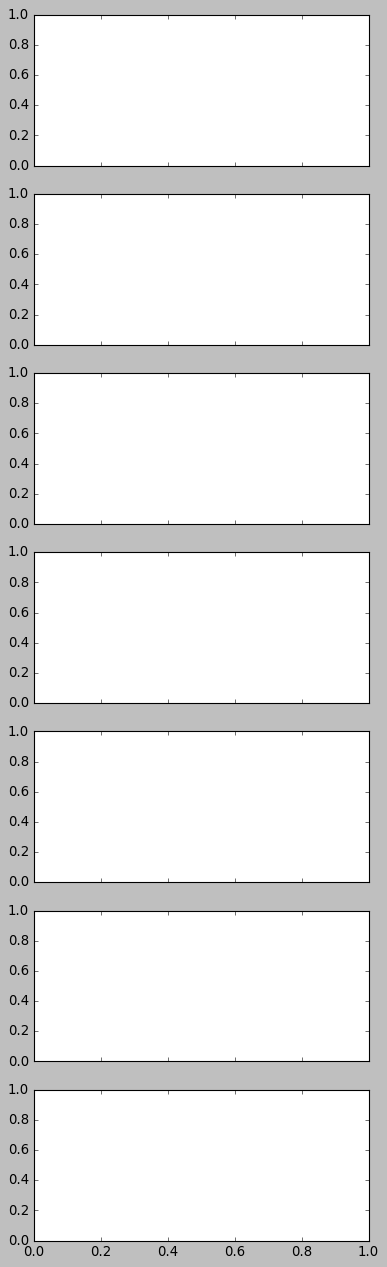

In [88]:
#plt.style.use('classic')
# IGNOR THIS LOL
fig, axs = plt.subplots(7, sharex = True, tight_layout = True, figsize = (5,16))

c = c3r2_kids_matches
k = kids_gold_table

# redshift sample
#axs[0].hist(c['U-G'], bins = 60, range = (-3,3), density = True, weights = c['w_d'], histtype='step')
axs[0].hist(c[f'MAG_GAAP_{c_filts[0]}'] - c[f'MAG_GAAP_{c_filts[1]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[0].hist(k[f'MAG_GAAP_{filts[0]}'] - k[f'MAG_GAAP_{filts[1]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[0].set_title('U-G')

#axs[1].hist(c['G-R'], bins = 60, range = (-3,3), density = True, weights = c['w_d'], histtype='step')
axs[1].hist(c[f'MAG_GAAP_{c_filts[1]}'] - c[f'MAG_GAAP_{c_filts[2]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[1].hist(k[f'MAG_GAAP_{filts[1]}'] - k[f'MAG_GAAP_{filts[2]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[1].set_title('G-R')

#axs[2].hist(c['R-I'], bins = 60, range = (-3,3), density = True, weights = c['w_d'], histtype='step')
axs[2].hist(c[f'MAG_GAAP_{c_filts[2]}'] - c[f'MAG_GAAP_{c_filts[3]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[2].hist(k[f'MAG_GAAP_{filts[2]}'] - k[f'MAG_GAAP_{filts[3]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[2].set_title('R-I')

#axs[3].hist(c['I-Z'], bins = 60, range = (-3,3), density = True, weights = c['w_d'], histtype='step')
axs[3].hist(c[f'MAG_GAAP_{c_filts[3]}'] - c[f'MAG_GAAP_{c_filts[4]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[3].hist(k[f'MAG_GAAP_{filts[3]}'] - k[f'MAG_GAAP_{filts[4]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[3].set_title('I-Z')

#axs[4].hist(c['Z-Y'], bins = 60, range = (-3,3), density = True, weights = c['w_d'], histtype='step')
axs[4].hist(c[f'MAG_GAAP_{c_filts[4]}'] - c[f'MAG_GAAP_{c_filts[5]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[4].hist(k[f'MAG_GAAP_{filts[4]}'] - k[f'MAG_GAAP_{filts[5]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[4].set_title('Z-Y')

#axs[5].hist(c['Y-J'], bins = 60, range = (-3,3), density = True, weights = c['w_d'], histtype='step')
axs[5].hist(c[f'MAG_GAAP_{c_filts[5]}'] - c[f'MAG_GAAP_{c_filts[6]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[5].hist(k[f'MAG_GAAP_{filts[5]}'] - k[f'MAG_GAAP_{filts[6]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[5].set_title('Y-J')

#axs[6].hist(c['J-H'], bins = 60, range = (-3,3), density = True, weights = c['w_d'], label = 'Calibration', histtype='step');
axs[6].hist(c[f'MAG_GAAP_{c_filts[6]}'] - c[f'MAG_GAAP_{c_filts[7]}'], bins = 60, range = (-3,3), density = True, histtype='step')
axs[6].hist(k[f'MAG_GAAP_{filts[6]}'] - k[f'MAG_GAAP_{filts[7]}'], bins = 60, range = (-3,3), density = True, label = 'Wide', histtype='step')
axs[6].set_title('J-H')

label = ['Deep', 'Wide']
fig.legend(label, loc='upper right')

In [ ]:
c3r2_kids_matches

In [93]:
kids_c3r2_matches

SeqNr,FLUX_AUTO_THELI,FLUXERR_AUTO_THELI,MAG_AUTO,MAGERR_AUTO_THELI,KRON_RADIUS_THELI,BackGr_THELI,Level_THELI,MU_THRESHOLD_THELI,MaxVal_THELI,MU_MAX_THELI,ISOAREA_WORLD_THELI,Xpos_THELI,Ypos_THELI,ALPHA_J2000,DELTA_J2000,A_WORLD,B_WORLD,THETA_J2000,ERRA_WORLD_THELI,ERRA_IMAGE_THELI,ERRB_WORLD_THELI,ERRB_IMAGE_THELI,THETA_SKY_THELI,ERRTHETA_SKY_THELI,THETA_WORLD_THELI,ERRTHETA_WORLD_THELI,FWHM_IMAGE_THELI,FWHM_WORLD_THELI,Flag_THELI,FLUX_RADIUS_THELI,NIMAFLAGS_ISO_THELI,CLASS_STAR_THELI,IMAFLAGS_ISO_THELI,X_WORLD_THELI,Y_WORLD_THELI,XY_WORLD_THELI,X2_WORLD_THELI,Y2_WORLD_THELI,ERRX2_IMAGE_THELI,ERRX2_WORLD_THELI,ERRXY_WORLD_THELI,ERRY2_WORLD_THELI,ERRXY_IMAGE_THELI,ERRY2_IMAGE_THELI,XM2_THELI,YM2_THELI,Corr_THELI,CXX_IMAGE_THELI,CXY_IMAGE_THELI,CYY_IMAGE_THELI,CXX_WORLD_THELI,CXY_WORLD_THELI,CYY_WORLD_THELI,ERRCXX_IMAGE_THELI,ERRCXY_IMAGE_THELI,ERRCYY_IMAGE_THELI,ERRCXX_WORLD_THELI,ERRCXY_WORLD_THELI,ERRCYY_WORLD_THELI,NPIX_THELI,XMIN_IMAGE_THELI,XMAX_IMAGE_THELI,YMIN_IMAGE_THELI,YMAX_IMAGE_THELI,A_THELI,B_THELI,POSANG_THELI,ERRTHETA_IMAGE_THELI,ELLIPTICITY_THELI,ELONGATION_THELI,ISO0_THELI,ISO1_THELI,ISO2_THELI,ISO3_THELI,ISO4_THELI,ISO5_THELI,ISO6_THELI,ISO7_THELI,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,MAG_LIM_u,MAG_LIM_g,MAG_LIM_r,MAG_LIM_i,MAG_ISO_THELI,MAGERR_ISO_THELI,MAG_ISOCOR_THELI,MAGERR_ISOCOR_THELI,MAG_BEST_THELI,MAGERR_BEST_THELI,MAG_APER_THELI,MAGERR_APER_THELI,FLUX_BEST_THELI,FLUXERR_BEST_THELI,FLUX_ISO_THELI,FLUXERR_ISO_THELI,FLUX_ISOCOR_THELI,FLUXERR_ISOCOR_THELI,FLUX_APER_4_THELI,FLUX_APER_5_THELI,FLUX_APER_6_THELI,FLUX_APER_7_THELI,FLUX_APER_8_THELI,FLUX_APER_9_THELI,FLUX_APER_10_THELI,FLUX_APER_11_THELI,FLUX_APER_12_THELI,FLUX_APER_13_THELI,FLUX_APER_14_THELI,FLUX_APER_15_THELI,FLUX_APER_16_THELI,FLUX_APER_17_THELI,FLUX_APER_18_THELI,FLUX_APER_19_THELI,FLUX_APER_20_THELI,FLUX_APER_25_THELI,FLUX_APER_30_THELI,FLUX_APER_35_THELI,FLUX_APER_40_THELI,FLUX_APER_45_THELI,FLUX_APER_50_THELI,FLUX_APER_55_THELI,FLUXERR_APER_4_THELI,FLUXERR_APER_5_THELI,FLUXERR_APER_6_THELI,FLUXERR_APER_7_THELI,FLUXERR_APER_8_THELI,FLUXERR_APER_9_THELI,FLUXERR_APER_10_THELI,FLUXERR_APER_11_THELI,FLUXERR_APER_12_THELI,FLUXERR_APER_13_THELI,FLUXERR_APER_14_THELI,FLUXERR_APER_15_THELI,FLUXERR_APER_16_THELI,FLUXERR_APER_17_THELI,FLUXERR_APER_18_THELI,FLUXERR_APER_19_THELI,FLUXERR_APER_20_THELI,FLUXERR_APER_25_THELI,FLUXERR_APER_30_THELI,FLUXERR_APER_35_THELI,FLUXERR_APER_40_THELI,FLUXERR_APER_45_THELI,FLUXERR_APER_50_THELI,FLUXERR_APER_55_THELI,Agaper_u,Bgaper_u,PAgaap_u,MAG_GAAP_u,MAGERR_GAAP_u,FLUX_GAAP_u,FLUXERR_GAAP_u,Agaper_g,Bgaper_g,PAgaap_g,MAG_GAAP_g,MAGERR_GAAP_g,FLUX_GAAP_g,FLUXERR_GAAP_g,Agaper_r,Bgaper_r,PAgaap_r,MAG_GAAP_r,MAGERR_GAAP_r,FLUX_GAAP_r,FLUXERR_GAAP_r,Agaper_i,Bgaper_i,PAgaap_i,MAG_GAAP_i,MAGERR_GAAP_i,FLUX_GAAP_i,FLUXERR_GAAP_i,Z_B_ugri,Z_B_MIN_ugri,Z_B_MAX_ugri,T_B_ugri,ODDS_ugri,Z_ML_ugri,T_ML_ugri,CHI_SQUARED_BPZ_ugri,M_0_ugri,FIELD_POS,PZ_full [351],Flag,MAG_GAAP_Z,MAGERR_GAAP_Z,FLUX_GAAP_Z,FLUXERR_GAAP_Z,GAAP_Flag_Z,GAAP_nexp_Z,MAG_GAAP_Y,MAGERR_GAAP_Y,FLUX_GAAP_Y,FLUXERR_GAAP_Y,GAAP_Flag_Y,GAAP_nexp_Y,MAG_GAAP_J,MAGERR_GAAP_J,FLUX_GAAP_J,FLUXERR_GAAP_J,GAAP_Flag_J,GAAP_nexp_J,MAG_GAAP_H,MAGERR_GAAP_H,FLUX_GAAP_H,FLUXERR_GAAP_H,GAAP_Flag_H,GAAP_nexp_H,MAG_GAAP_Ks,MAGERR_GAAP_Ks,FLUX_GAAP_Ks,FLUXERR_GAAP_Ks,GAAP_Flag_Ks,GAAP_nexp_Ks,EXTINCTION_Z,EXTINCTION_Y,EXTINCTION_J,EXTINCTION_H,EXTINCTION_Ks,MAG_LIM_Z,MAG_LIM_Y,MAG_LIM_J,MAG_LIM_H,MAG_LIM_Ks,GAAP_Flag_u,GAAP_Flag_g,GAAP_Flag_r,GAAP_Flag_i,MAG_GAAPadapt_Z,MAG_GAAPadapt_Y,MAG_GAAPadapt_J,MAG_GAAPadapt_H,MAG_GAAPadapt_Ks,MAGERR_GAAPadapt_Z,MAGERR_GAAPadapt_Y,MAGERR_GAAPadapt_J,MAGERR_GAAPadapt_H,MAGERR_GAAPadapt_Ks,MAG_GAAPadapt_u,MAG_GAAPadapt_g,MAG_GAAPadapt_r,MAG_GAAPadapt_i,MAGERR_GAAPadapt_u,MAGERR_GAAPadapt_g,MAGERR_GAAPadapt_r,MAGERR_GAAPadapt_i,Z_B,Z_B_MIN,Z_B_MAX,T_B,ODDS,Z_ML,T_ML,CHI_SQUARED_BPZ,M_0,BPZ_FILT,NBPZ_FILT,BPZ_NONDETFILT,NBPZ_NONDETFILT,BPZ_FLAGFILT,NBPZ_FLAGFILT,GAAP_Flag_ugriZYJHKs,MASK,recal_weight
"""""",ct,ct,mag,c